In [1]:
print(5)

5


In [2]:
from io import StringIO
import requests
import json
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
url = "https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1577223283&period2=9999999999&interval=1d&events=history&includeAdjustedClose=true"
response = requests.get(url)
response.text
df = pd.read_csv(StringIO(response.text),index_col = "Date",parse_dates = ["Date"])
df_plot = df[{'Open','High','Low','Close'}]

In [3]:
df_plot.tail()

,Close,Low,High,Open
Date,,,,
2021-03-15,55907.199219,55393.164063,60540.992188,59267.429688
2021-03-16,56804.902344,53555.027344,56833.179688,55840.785156
2021-03-17,58870.894531,54528.628906,58969.816406,56825.828125
2021-03-18,57858.921875,54253.578125,60116.250000,58893.078125
2021-03-19,58349.320313,56660.320313,58494.398438,57699.785156


In [4]:
#計算ma
def moving_average(data,periods):
    return data['Close'].rolling(periods).mean()

In [5]:
df_copy = df.copy()
df_copy['min'] = df_copy['Low'].rolling(9).min()
df_copy['max'] = df_copy['High'].rolling(9).min()
df_copy['RSV'] = (df_copy['Close'] - df_copy['min']) / (df_copy['max'] - df_copy['min'])
df_copy = df_copy.dropna()
K_list = [50]
for index,rsv in enumerate(list(df_copy['RSV'])):
    K_yesterday = K_list[index]
    K_today = 2/3 * K_yesterday + 1/3 *rsv
    K_list.append(K_today)
df_copy['K'] = K_list[1:]
D_list = [50]
for index,K in enumerate(list(df_copy['K'])):
    D_yesterday = D_list[index]
    D_today = 2/3 * D_yesterday + 1/3 *K
    D_list.append(D_today)
df_copy['D'] = D_list[1:]

In [6]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-03-15,59267.429688,60540.992188,55393.164063,55907.199219,55907.199219,6.641937e+10
2021-03-16,55840.785156,56833.179688,53555.027344,56804.902344,56804.902344,5.974980e+10
2021-03-17,56825.828125,58969.816406,54528.628906,58870.894531,58870.894531,6.025831e+10
2021-03-18,58893.078125,60116.250000,54253.578125,57858.921875,57858.921875,5.574604e+10
2021-03-19,57699.785156,58494.398438,56660.320313,58349.320313,58349.320313,5.616550e+10


In [7]:
#計算KD值
'''
step1 計算RSV:(今天的收盤價 - 最近9天的最低價)/(最近9天的最高價 - 最近9天的最低價)
step2 計算K值: K = 2/3 * (昨天的K值) + 1/3 * (今日RSV)
step3 計算D值: K = 2/3 * (昨天的D值) + 1/3 * (今日的K值)
'''
def KD(data):
    df_copy = data.copy()
    df_copy['min'] = df_copy['Low'].rolling(9).min()
    df_copy['max'] = df_copy['High'].rolling(9).min()
    df_copy['RSV'] = (df_copy['Close'] - df_copy['min']) / (df_copy['max'] - df_copy['min'])
    df_copy = df_copy.dropna()
    K_list = [50]
    for index,rsv in enumerate(list(df_copy['RSV'])):
        K_yesterday = K_list[index]
        K_today = 2/3 * K_yesterday + 1/3 *rsv
        K_list.append(K_today)
    df_copy['K'] = K_list[1:]
    D_list = [50]
    for index,K in enumerate(list(df_copy['K'])):
        D_yesterday = D_list[index]
        D_today = 2/3 * D_yesterday + 1/3 *K
        D_list.append(D_today)
    df_copy['D'] = D_list[1:]
    use_df = pd.merge(data,df_copy[['K','D']],left_index=True,right_index=True,how='left')
    return use_df

In [8]:
KD(df).tail(10)

,Open,High,Low,Close,Adj Close,Volume,K,D
Date,,,,,,,,
2021-03-10,54824.011719,57258.253906,53290.890625,56008.550781,56008.550781,5.729558e+10,2.671947,2.170091
2021-03-11,55963.179688,58091.062500,54484.593750,57805.121094,57805.121094,5.677234e+10,3.222615,2.520932
2021-03-12,57821.218750,57996.621094,55376.648438,57332.089844,57332.089844,5.568994e+10,3.529191,2.857018
2021-03-13,57343.371094,61683.863281,56217.972656,61243.085938,61243.085938,6.066983e+10,4.234079,3.316039
2021-03-14,61221.132813,61597.917969,59302.316406,59302.316406,59302.316406,4.390123e+10,4.947368,3.859815
2021-03-15,59267.429688,60540.992188,55393.164063,55907.199219,55907.199219,6.641937e+10,4.243015,3.987548
2021-03-16,55840.785156,56833.179688,53555.027344,56804.902344,56804.902344,5.974980e+10,3.695107,3.890068
2021-03-17,56825.828125,58969.816406,54528.628906,58870.894531,58870.894531,6.025831e+10,3.271330,3.683822
2021-03-18,58893.078125,60116.250000,54253.578125,57858.921875,57858.921875,5.574604e+10,2.610743,3.326129


In [9]:
#繪製K線圖套件
import mplfinance as mpf
from matplotlib import dates as mdates
from matplotlib import ticker as mticker
from mpl_finance import candlestick_ohlc
from matplotlib.dates import DateFormatter
import datetime as dt

c:\users\fetty\appdata\local\programs\python\python37\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


In [10]:
data_plot = df_plot.copy()
data_plot['Datetime'] = df_plot.index
data_plot = data_plot.reset_index()
data_plot = data_plot[['Datetime','Open','High','Low','Close']]
data_plot['Datetime'] = mdates.date2num(data_plot['Datetime'])

Text(0.5, 0.98, 'BTC-USD')

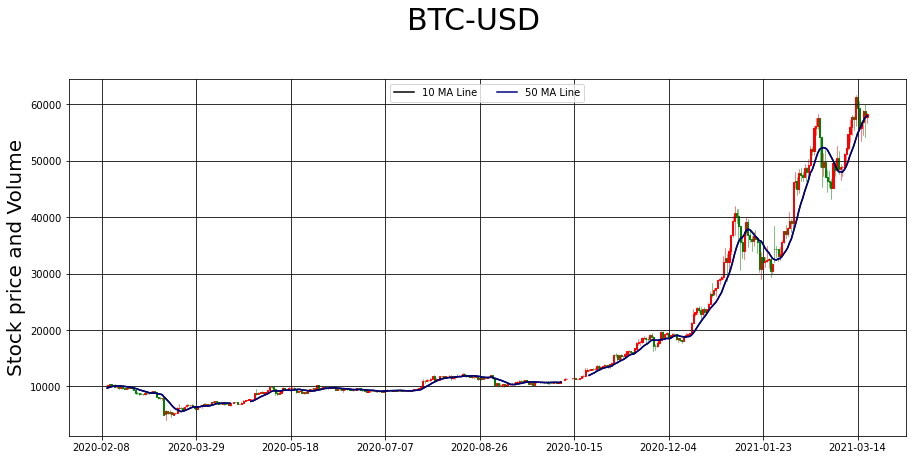

In [11]:
#畫K線圖
ma_10 = moving_average(df,10)
ma_50 = moving_average(df,50)
length = len(data_plot['Datetime'].values[49:])
figure = plt.figure(facecolor='white',figsize=(15,10))
ax1 = plt.subplot2grid((6,4),(0,0),rowspan=4,colspan=4,facecolor='white')
candlestick_ohlc(ax1,data_plot.values[-length:],width=0.6,colorup='red',colordown='green')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax1.plot(data_plot['Datetime'].values[-length:],ma_10[-length:],'black',label='10 MA Line',linewidth=1.5)
ax1.plot(data_plot['Datetime'].values[-length:],ma_10[-length:],'navy',label='50 MA Line',linewidth=1.5)
ax1.legend(loc='upper center',ncol=2)
ax1.grid(True,color='black')
plt.ylabel('Stock price and Volume',fontsize=20)
plt.suptitle('BTC-USD',color='black',fontsize=30)